In [1]:
import open3d as o3d
import cv2
import numpy as np
import time
from apriltag import apriltag
from matplotlib import pyplot as plt

#recognize targets on the board->extract extrinsic->project targets back to the world (project all points)->compute difference

In [2]:
#try with opencv chessboard
chess_img = cv2.imread('download.jpeg',cv2.IMREAD_GRAYSCALE)
print(chess_img)
ret, corners = cv2.findChessboardCorners(chess_img, (7,6),None)
print(corners.shape)
print(corners)

[[ 70  70  70 ...  87  87  90]
 [ 70  70  70 ...  87  88  90]
 [ 70  70  70 ...  87  88  90]
 ...
 [255 212 154 ...  69  69  69]
 [240 216 132 ...  69  69  69]
 [143  98  55 ...  42  42  42]]
(42, 1, 2)
[[[ 37.178814 154.21387 ]]

 [[ 43.5      133.5     ]]

 [[ 50.       112.      ]]

 [[ 56.925537  92.53533 ]]

 [[ 63.407578  73.52075 ]]

 [[ 69.692726  55.614994]]

 [[ 76.        39.5     ]]

 [[ 56.5      159.5     ]]

 [[ 63.5      138.5     ]]

 [[ 70.       116.5     ]]

 [[ 76.5       95.5     ]]

 [[ 82.        77.      ]]

 [[ 89.        58.      ]]

 [[ 94.        41.5     ]]

 [[ 78.       165.      ]]

 [[ 84.       142.      ]]

 [[ 91.       121.5     ]]

 [[ 97.5       98.5     ]]

 [[102.5       78.5     ]]

 [[109.        59.5     ]]

 [[113.5       42.5     ]]

 [[100.5      171.5     ]]

 [[107.       147.5     ]]

 [[112.5      124.      ]]

 [[118.       102.5     ]]

 [[124.        81.5     ]]

 [[129.        62.5     ]]

 [[134.5       43.5     ]]

 [[125.      

({'hamming': 1, 'margin': 41.60295867919922, 'id': 0, 'center': array([997.30789008, 142.13100016]), 'lb-rb-rt-lt': array([[1023.34844971,  132.89691162],
       [ 962.79351807,  115.74077606],
       [ 970.19012451,  151.74707031],
       [1034.06884766,  170.23899841]])}, {'hamming': 1, 'margin': 56.31468963623047, 'id': 1, 'center': array([915.53624262, 118.76113604]), 'lb-rb-rt-lt': array([[943.80047607, 110.20281219],
       [882.42663574,  92.29566956],
       [884.73760986, 128.08686829],
       [949.621521  , 146.00648499]])}, {'hamming': 0, 'margin': 56.944828033447266, 'id': 2, 'center': array([832.2575228 ,  94.85979984]), 'lb-rb-rt-lt': array([[863.07354736,  86.77640533],
       [800.91015625,  68.45936584],
       [798.11083984, 103.81686401],
       [864.56311035, 122.06723785]])}, {'hamming': 0, 'margin': 54.00941467285156, 'id': 7, 'center': array([921.73058986, 172.16635577]), 'lb-rb-rt-lt': array([[952.14526367, 160.86180115],
       [885.63092041, 142.17160034],
   

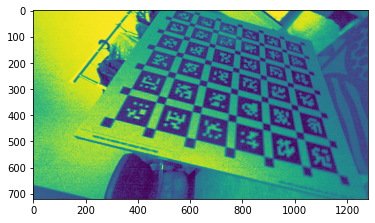

In [3]:
color_image = cv2.imread('/home/yunke/3dv_proj/0522/training_checkerboard/rgb/29.551055.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(color_image)
#enhance image
color_image = cv2.equalizeHist(color_image)
plt.imshow(color_image)
def recognize_target(color_image):
    detector = apriltag("tag36h11")
    result = detector.detect(color_image)
    return result

print(recognize_target(color_image))

In [4]:

def get_extrinsic(rcgs, mtx, u_length):
    #input: april tag recognization reult
    #output: rot 3*3, trans 3*1
    
    #define full object points
    objp = np.zeros((6*6,3), np.float32)
    objp[:,:2] = np.mgrid[0:6,0:6].T.reshape(-1,2)
    
    objp = objp*(u_length)
    
    #find index of extracted points
    ids = []
    centers = []
    for rcg in rcgs:
        ids.append(rcg['id'])
        centers.append(rcg['center'])
        
    #get recognized obj points
    tgt_objp = objp[ids,:]
    tgts = np.asarray(centers)
    #print(tgt_objp)
#     print(tgts.shape)
#     print(tgt_objp.shape)
#     print(mtx.shape)
    
    #solve for the extrinsic:
    success, rvecs, tvecs = cv2.solvePnP(tgt_objp, tgts, mtx, np.zeros(4))
#     print(success)
    #convert rotation vector to rotation matrix
    rmtxs = np.zeros((3,3))
    cv2.Rodrigues(rvecs, rmtxs)
    
    # calculate homogeneous transformation matrix 
    trans = np.concatenate([rmtxs, tvecs],axis = 1)
    trans = np.concatenate([trans,np.asarray([[0.,0.,0.,1.]])],axis = 0)
    
    return trans


In [5]:
# source_color = o3d.io.read_image("/home/yunke/3dv_proj/0522/training_checkerboard/rgb/29.551055.png")
# source_depth = o3d.io.read_image("/home/yunke/3dv_proj/0522/training_checkerboard/depth/29.551066.png")
# print(source_depth)
def get_pcd(color_img, depth_img):
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
            color_img, depth_img,depth_scale=642.0)

    intrinsics = o3d.camera.PinholeCameraIntrinsic()
    intrinsics.set_intrinsics(1280, 720, 632.627563, 631.686951, 634.963169, 370.526409)

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsics)
    return pcd




# test the point cloud and original points
pcd.transform(np.linalg.inv(trans))
#o3d.visualization.draw_geometries([pcd])
pcd_1 = o3d.geometry.PointCloud()
objp = np.zeros((6*6,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:6].T.reshape(-1,2)

objp = objp*(t_a*(1+t_b))
pcd_1.points = o3d.utility.Vector3dVector(objp)
o3d.visualization.draw_geometries([pcd,pcd_1])
pcd.transform(trans)

In [6]:
#given image coords, get 3d pos
def img_to_3d(uvs, ds, mtx):
    #uvs: N*2, img coordinates
    #mtx: 3*3
    #output: N*3, world coordinates
    
    #aug uvs
    uvs_1 = np.concatenate([uvs,np.ones((uvs.shape[0],1))],axis = 1)
    #normalized 3d
    n_x_s = np.dot(mtx,uvs_1.T).T
    
    x_s = np.multiply(x_s,ds/640)
    
    return x_s
    

In [7]:

def select_pcd(pcd, trans, thr, boundary):
    #suppose the plane in world coordinate is x-y plane
    #inputs: pcd, original point cloud
    #trans: extrinsic 4*4 
    # thr: inlier threshold
    #boundary: x, y boundary
    
    #output: inlier, int index (K,)
    
    #transform points to world coordinate
    points = np.asarray(pcd.points) #N*3
    nor_points = np.concatenate([points,np.ones((points.shape[0],1))],axis = 1) #N*4
    world_points = np.dot(trans,nor_points.T).T #N*4
    
    #select by z value
    xs = world_points[:,0].reshape((-1,1))
    ys = world_points[:,1].reshape((-1,1))
    zs = world_points[:,2].reshape((-1,1))
    
    index = np.arange(0,zs.shape[0],1)

    mask = np.concatenate([abs(zs)<thr,xs>0,xs<boundary,ys>0,ys<boundary],axis = 1)
    inlier = index[np.all(mask,axis = 1)]
    
    return inlier

# test select pcd
inlier = select_pcd(pcd, np.linalg.inv(trans), 0.01,boundary)
pcd_plane = pcd.select_down_sample(inlier)
o3d.visualization.draw_geometries([pcd_plane])

In [8]:
def transform_plane(plane,trans):
    return np.dot(np.linalg.inv(trans).T,plane)

In [9]:
def pcd_to_data(pcd, plane, mtx, inlier):
    #input: pcd: o3d point cloud
    #plane: 4*1 vector
    #inlier: selected index
    #output: img coordinates u,v, z, z_true
    pcd_plane = pcd.select_down_sample(inlier)
    points = np.asarray(pcd_plane.points)
    #o3d.visualization.draw_geometries([pcd_plane])
    data = []
    #print(points)
    
    cam_mat = mtx
    z = points[:,2]
    #print(z)
    z_u_v_1 = np.dot(cam_mat,np.transpose(points)).T
    #print(z_u_v_1)
    u_v_1 = z_u_v_1/z[:,None]
    u_v_1 = u_v_1.astype(int)
    #print(u_v_1.shape)
    #print(u_v_1)
    l = np.transpose(np.dot(np.linalg.inv(cam_mat),np.transpose(u_v_1)))
    n = np.asarray(plane)[0:3]
    d = np.asarray(plane)[3]
    z_t = -d/np.dot(l,n)
    
    seq = np.arange(z.shape[0])
    #seq = seq[z<2.0]
    data = list(zip(u_v_1[seq,0].tolist(),u_v_1[seq,1].tolist(),z[seq].tolist(),z_t[seq].tolist()))
    
    return data


# test pcd to data
plane_cam = transform_plane(np.asarray([0.,0.,1.,0.]),trans)
print(plane_cam.shape)
data = pcd_to_data(pcd,plane_cam,mtx,inlier)
print(data[-100:])

In [10]:
import random

def source_img_to_data(source_color, source_depth, training_data, downsample):
    #recognize targets on the board->extract extrinsic->project targets back to the world (project all points)->compute difference
    t_a = 0.088
    t_b = 0.3
    mtx = np.asarray([[632.627563, 0., 634.963169], 
                 [0.,631.686951,370.526409],
                  [0.,0.,1.]])
    boundary = t_a * (1 + t_b) * 5
    thr = 0.006
    
    # Blur the image
    source_depth_blur = cv2.bilateralFilter(np.asarray(source_depth).astype(np.float32),2,200,1.5)
    
    sobelx_d = cv2.Sobel(np.asarray(source_depth_blur),cv2.CV_64F,1,0,ksize=5)
    sobely_d = cv2.Sobel(np.asarray(source_depth_blur),cv2.CV_64F,0,1,ksize=5)
    sobelx_cl = cv2.Sobel(np.asarray(source_color),cv2.CV_64F,1,0,ksize=5)
    sobely_cl = cv2.Sobel(np.asarray(source_color),cv2.CV_64F,0,1,ksize=5)
    laplacian = cv2.Laplacian(np.asarray(source_color),cv2.CV_64F)
    
    
    # get tag positions and ids
    color_image = cv2.cvtColor(np.asarray(source_color), cv2.COLOR_BGR2GRAY)
    color_image = cv2.equalizeHist(color_image)
    result = recognize_target(color_image)
    
    if len(result)<5:
        return
    
    # cal extrinsic matrix
    trans = get_extrinsic(result, mtx, t_a*(1+t_b))
 
    # get point cloud from rgb-d images
    o3d_depth_blur = o3d.geometry.Image(source_depth_blur)
    pcd = get_pcd(source_color,o3d_depth_blur)
    #o3d.visualization.draw_geometries([pcd])
    # select points in the convex hull 
    inlier = select_pcd(pcd, np.linalg.inv(trans), thr, boundary)

    #transform the plane from world coord. to camera coord.
    plane_cam = transform_plane(np.asarray([0.,0.,1.,0.]), trans)

    # get dataset (u, v, z, z_t) from inlier
    data = pcd_to_data(pcd, plane_cam, mtx, inlier)
    
    # calc depth images gradient, color intensity and color images gradient
    # print(np.max(sobely))
    for i in range(len(data)):
        u = data[i][0]
        v = data[i][1]
        sobelx_i_d = sobelx_d[v,u]
        sobely_i_d = sobely_d[v,u]
        sobelx_i_cl = sobelx_cl[v,u]
        sobely_i_cl = sobely_cl[v,u]
        
        rand = random.uniform(0.,1.0)
        
        select = 1
        
        if downsample:
            select = rand<0.05
        
        if abs(sobelx_i_d) < 5000 and abs(sobely_i_d) < 5000 and select: #500
            temp = list(data[i])
            temp.append(sobelx_i_d)
            temp.append(sobely_i_d)
            temp=temp+np.asarray(source_color)[v,u].tolist()
            temp=temp+laplacian[v,u].tolist()
            temp=temp+sobelx_i_cl.tolist()
            temp=temp+sobely_i_cl.tolist()
            training_data.append(temp)
            

    

In [11]:
training_data = []
# source_img_to_data(source_color, source_depth, training_data)
# print(training_data[0:5])

In [12]:
import os
import glob

path1 = "/home/yunke/3dv_proj/0522/training_checkerboard/rgb"
path2 = "/home/yunke/3dv_proj/0522/training_checkerboard/depth"

filelist1 = []
filelist2 = []


for filename in glob.glob(path1+'/*.png'):
    filelist1.append(filename)
        
        
for filename in glob.glob(path2+'/*.png'):
    filelist2.append(filename)
        
filelist1.sort() 
filelist2.sort()   
print(filelist1[0:5])
print(filelist2[0:5])

['/home/yunke/3dv_proj/0522/training_checkerboard/rgb/10.017722.png', '/home/yunke/3dv_proj/0522/training_checkerboard/rgb/10.084377.png', '/home/yunke/3dv_proj/0522/training_checkerboard/rgb/10.117722.png', '/home/yunke/3dv_proj/0522/training_checkerboard/rgb/10.184400.png', '/home/yunke/3dv_proj/0522/training_checkerboard/rgb/10.251055.png']
['/home/yunke/3dv_proj/0522/training_checkerboard/depth/10.017733.png', '/home/yunke/3dv_proj/0522/training_checkerboard/depth/10.084400.png', '/home/yunke/3dv_proj/0522/training_checkerboard/depth/10.117733.png', '/home/yunke/3dv_proj/0522/training_checkerboard/depth/10.184400.png', '/home/yunke/3dv_proj/0522/training_checkerboard/depth/10.251066.png']


In [24]:
#source_color = o3d.io.read_image("/home/yunke/3dv_proj/bias correction/scan0512/color.png")

for i in range(0,len(filelist1),10):
    source_color = o3d.io.read_image(filelist1[i])  
    source_depth = o3d.io.read_image(filelist2[i])  
    #augmentation
    source_color_1 = o3d.geometry.Image(cv2.flip(np.asarray(source_color),0))
    source_color_2 = o3d.geometry.Image(cv2.flip(np.asarray(source_color),1))
    source_color_3 = o3d.geometry.Image(cv2.flip(np.asarray(source_color),-1))
    source_depth_1 = o3d.geometry.Image(cv2.flip(np.asarray(source_depth),0))
    source_depth_2 = o3d.geometry.Image(cv2.flip(np.asarray(source_depth),1))
    source_depth_3 = o3d.geometry.Image(cv2.flip(np.asarray(source_depth),-1))
    source_img_to_data(source_color, source_depth, training_data, 1)
    source_img_to_data(source_color_1, source_depth_1, training_data, 1)
    source_img_to_data(source_color_2, source_depth_2, training_data, 1)
    source_img_to_data(source_color_3, source_depth_3, training_data, 1)
    if i%100==0:
        print(i)
    
print(len(training_data))
training_data = np.asarray(training_data)


0


KeyboardInterrupt: 

In [ ]:
# with open('/home/yunke/3dv_proj/0522/training_data.txt', 'w') as fp:
#     fp.write('\n'.join('%s %s %s %s %s %s %s %s %s' % x for x in training_data))
print(training_data.shape)
np.savetxt('/home/yunke/3dv_proj/0522/training_array_data.txt',training_data)

In [13]:
######modify the image with learned model
#each image->only get the close part->for each pixel -> compute X data -> apply model -> get new image

from joblib import dump, load
model = load('/home/yunke/3dv_proj/bias correction/RF_learned_model.joblib')

def get_close_pixels(depth_img):
    pixel_mtrx = []
    h = depth_img.shape[0]
    w = depth_img.shape[1]
    flat_img = depth_img.reshape((-1,))
    seq = np.arange(0,flat_img.shape[0],1)
    large = (flat_img < 1.5*642).reshape((-1,1))
    small = (flat_img > 0.05*642).reshape((-1,1))
    good = np.multiply(large,small)[:,0]
    seq = seq[good]
    v = ((seq.astype(int))/1280).reshape((-1,1))
    u = ((seq.astype(int))%1280).reshape((-1,1))
    pixel_mtrx = np.concatenate([v,u],axis=1).tolist()
    
#     for i in range(depth_img.shape[0]):
#         seq = np.arange(depth_img.shape[1])
#         z = depth_img[i,:]
#         large = (z < 1.5*642).reshape((-1,1))
#         small = (z > 0.05*642).reshape((-1,1))
#         good = np.multiply(large,small)[:,0]
#         #print(good.shape)
#         seq = seq[good]
#         mtrx_i = np.concatenate([i*np.ones((seq.shape[0],1)),seq.reshape((-1,1))],axis=1).tolist()
#         pixel_mtrx=pixel_mtrx+mtrx_i
    
    return pixel_mtrx

In [14]:
# test
depth_img = o3d.io.read_image("/home/yunke/3dv_proj/0522/training_checkerboard/depth/32.217733.png")
depth_img = np.asarray(depth_img)
output = get_close_pixels(depth_img)
print(len(output))
print(np.max(depth_img))

387105
2296


In [15]:
def get_pixel_info(pixel_mtrx, source_color, source_depth):
    # Blur the image
    depth_img = np.asarray(source_depth)
    color_img = np.asarray(source_color)
    source_depth_blur = cv2.bilateralFilter(depth_img.astype(np.float32),2,200,1.5)
    
    
    sobelx_d = cv2.Sobel(np.asarray(source_depth_blur),cv2.CV_64F,1,0,ksize=5)
    sobely_d = cv2.Sobel(np.asarray(source_depth_blur),cv2.CV_64F,0,1,ksize=5)
    sobelx_cl = cv2.Sobel(np.asarray(source_color),cv2.CV_64F,1,0,ksize=5)
    sobely_cl = cv2.Sobel(np.asarray(source_color),cv2.CV_64F,0,1,ksize=5)
    laplacian = cv2.Laplacian(color_img,cv2.CV_64F)
    
    #plt.imshow(laplacian)
    #plt.imshow(sobely_d)

    pixel_info = []
    
    # calc depth images gradient, color intensity and color images gradient
    # print(np.max(sobely))
    for i in range(len(pixel_mtrx)):
        v = int(pixel_mtrx[i][0])
        u = int(pixel_mtrx[i][1])
        sobelx_i_d = sobelx_d[v,u]
        sobely_i_d = sobely_d[v,u]
        sobelx_i_cl = sobelx_cl[v,u]
        sobely_i_cl = sobely_cl[v,u]
        
        if abs(sobelx_i_d) < 5000 and abs(sobely_i_d) < 5000: #500
            temp = []
            temp.append(pixel_mtrx[i][1]/1280.)
            temp.append(pixel_mtrx[i][0]/720.)
            temp.append(source_depth_blur[v,u]/642.0)
            temp.append(sobelx_i_d/500.)
            temp.append(sobely_i_d/500.)
            temp=temp+(color_img[v,u]/255.).tolist()
            temp=temp+(laplacian[v,u]/255.).tolist()
            temp=temp+(sobelx_i_cl/2000.).tolist()
            temp=temp+(sobely_i_cl/2000.).tolist()
            pixel_info.append(temp)
    
    
    return pixel_info

In [16]:
source_depth = o3d.io.read_image("/home/yunke/3dv_proj/0522/training_checkerboard/depth/32.217733.png")
print(np.mean(np.asarray(source_depth)))
source_color = o3d.io.read_image("/home/yunke/3dv_proj/0522/training_checkerboard/rgb/32.217733.png") 
pixel_info = get_pixel_info(output, source_color, source_depth)
print(pixel_info[2000:2010])

227.33419162326388
[[0.5875, 0.007760416666666667, 0.764797507788162, 0.0400955810546875, -0.04314404296875, 0.16862745098039217, 0.1411764705882353, 0.10588235294117647, 0.13725490196078433, 0.12941176470588237, 0.11372549019607843, 0.6285, 0.7335, 0.6565, -0.8735, -1.0775, -0.7585], [0.58828125, 0.007761501736111111, 0.764797507788162, -0.0022862548828125, -0.0363836669921875, 0.24705882352941178, 0.2235294117647059, 0.18823529411764706, -0.01568627450980392, -0.00784313725490196, -0.058823529411764705, 0.729, 0.8165, 0.612, -1.061, -1.2415, -0.87], [0.5890625, 0.0077625868055555556, 0.764797507788162, -0.058096435546875, -0.0400010986328125, 0.30980392156862746, 0.29411764705882354, 0.2235294117647059, -0.050980392156862744, -0.054901960784313725, -0.03137254901960784, 0.7595, 0.821, 0.554, -1.0505, -1.196, -0.831], [0.58984375, 0.007763671875, 0.7642039836752823, -0.12152166748046875, -0.04399969482421875, 0.3568627450980392, 0.34509803921568627, 0.2627450980392157, -0.039215686274

In [17]:
import copy

def pixel_info_to_correction(pixel_info, depth):
    
    depth_image = np.asarray(depth)
    depth_image = cv2.bilateralFilter(depth_image.astype(np.float32),2,200,1.5)
    #get predicted correction
    data = np.asarray(pixel_info)
    X = data
    #print(X.shape)
    y = model.predict(X)
    #print(y)
    #correct image
    new_depth_img = copy.copy(depth_image)
    v = (720*data[:,1]).astype(int).tolist()
    u = (1280*data[:,0]).astype(int).tolist()
    
    new_depth_img[v,u] = y.reshape((-1,))*642.0/5000.0+depth_image[v,u]
    #print(np.mean(depth_image))
        
    return new_depth_img
    

227.33419162326388


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


226.7461


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished


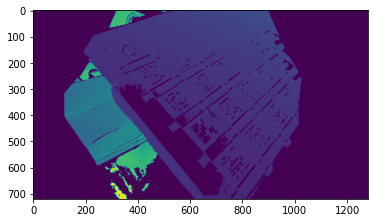

In [18]:
from PIL import Image

print(np.mean(np.asarray(source_depth)))
new_depth_img = pixel_info_to_correction(pixel_info, source_depth)
print(np.mean(np.asarray(new_depth_img)))
plt.imshow(new_depth_img)


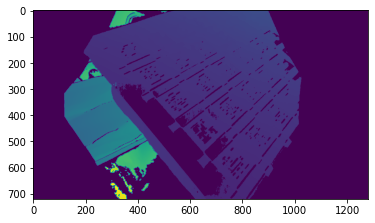

In [19]:
plt.imshow(depth_img)

In [20]:
def get_err_image(source_color,depth):
    #print(np.mean(depth))
    t_a = 0.088
    t_b = 0.3
    mtx = np.asarray([[632.627563, 0., 634.963169], 
                 [0.,631.686951,370.526409],
                  [0.,0.,1.]])
    boundary = t_a * (1 + t_b) * 5
    thr = 0.01
    
    # get tag positions and ids
    color_image = cv2.cvtColor(np.asarray(source_color), cv2.COLOR_BGR2GRAY)
    color_image = cv2.equalizeHist(color_image)
    result = recognize_target(color_image)
    
    #print(len(result))
    
    if len(result)<5:
        return 0, 0
    
    # cal extrinsic matrix
    trans = get_extrinsic(result, mtx, t_a*(1+t_b))
    #print(trans)
 
    # get point cloud from rgb-d images
    blur_depth = cv2.bilateralFilter(np.asarray(depth).astype(np.float32),2,200,1.5)
    o3d_blur_depth = o3d.geometry.Image(blur_depth)
    pcd = get_pcd(source_color,o3d_blur_depth)
    
    #print(np.mean(np.asarray(pcd.points)))
    # select points in the convex hull 
    inlier = select_pcd(pcd, np.linalg.inv(trans), thr, boundary)
    #o3d.visualization.draw_geometries([pcd.select_down_sample(inlier)])

    #transform the plane from world coord. to camera coord.
    plane_cam = transform_plane(np.asarray([0.,0.,1.,0.]), trans)

    # get dataset (u, v, z, z_t) from inlier
    data = np.asarray(pcd_to_data(pcd, plane_cam, mtx, inlier))
    
    #create new image
    depth_img = np.asarray(blur_depth)
    err_image = np.zeros((depth_img.shape))
    
    #get u,v
    u = data[:,0].astype(int)
    v = data[:,1].astype(int)
    err = abs(data[:,3]-data[:,2])
    err_image[v,u] = err
    
    #examine data
    true_image = copy.copy(depth_img)
    true_image[v,u] = data[:,3]*642.
    o3d_true_image = o3d.geometry.Image(true_image)
    true_pcd = get_pcd(source_color,o3d_true_image)
    inlier = select_pcd(true_pcd, np.linalg.inv(trans), thr, boundary)
    #o3d.visualization.draw_geometries([true_pcd.select_down_sample(inlier)])
    
    return err_image, data


In [21]:
import matplotlib



def depth_to_new_depth(source_color,source_depth,filename):
    #source depth --get_close_pixel--> pixels
    depth_img = np.asarray(source_depth)
    pixel_mtrx = get_close_pixels(depth_img)
    
    #source depth, source color --pixel_info--> model input
    pixel_info = get_pixel_info(pixel_mtrx, source_color, source_depth)
    
    #depth, pixel_info -> new depth img
    new_depth_img = pixel_info_to_correction(pixel_info, source_depth)
    
    #save image
    matplotlib.image.imsave(filename, new_depth_img)
    
    return new_depth_img
    

In [22]:
new_depth_img = depth_to_new_depth(source_color,source_depth,"/home/yunke/3dv_proj/new_depth.png")
o3d_new_depth_img = o3d.geometry.Image(new_depth_img)
new_err_img = get_err_image(source_color,o3d_new_depth_img)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished


In [23]:
print(len("/home/yunke/3dv_proj/0522/training_checkerboard/depth/"))

54


In [24]:
org_errs = []
new_errs = []
org_datas = []
new_datas = []

err_depth = []

total_pixel_info = []

for i in range(5,len(filelist1),10):
    source_color = o3d.io.read_image(filelist1[i])  
    source_depth = o3d.io.read_image(filelist2[i])  
    filename = "/home/yunke/3dv_proj/0522/training_checkerboard/new_depth_img/"+filelist2[i][54:]
    
    new_depth_img = depth_to_new_depth(source_color,source_depth,filename)
    o3d_new_depth_img = o3d.geometry.Image(new_depth_img)
    
    org_err_img,org_data = get_err_image(source_color,source_depth)
    new_err_img,new_data = get_err_image(source_color,o3d_new_depth_img) 
    
    if not np.sum(org_err_img)==0: 
        org_errs.append(np.mean(org_err_img))
        new_errs.append(np.mean(new_err_img))
    
        org_datas += org_data.tolist()
        new_datas += new_data.tolist()
    
    if i%200==5:
        print(i)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.7s finished


5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

205


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

405


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

605


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

805


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

1005


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

In [25]:
print(sum(org_errs))
print(sum(new_errs))

0.04417868919423419
0.03076831601048594


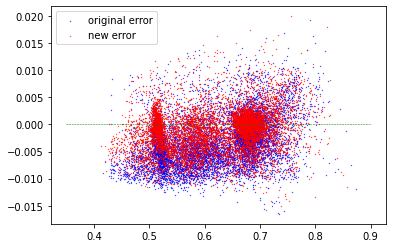

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [26]:
org_z = [org_datas[i][2] for i in range(0, len(org_datas), 1000)]
new_z = [new_datas[i][2] for i in range(0, len(new_datas), 1000)]
org_e = [org_datas[i][3]-org_datas[i][2] for i in range(0, len(org_datas), 1000)]
new_e = [new_datas[i][3]-new_datas[i][2] for i in range(0, len(new_datas), 1000)]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(org_z, org_e, s=0.1, c='b', marker="o", label='original error')
ax1.scatter(new_z,new_e, s=0.1, c='r', marker="o", label='new error')
ax1.plot([0.35, 0.9],[0, 0],'--',c='g', linewidth = 0.5)
plt.legend(loc='upper left');
plt.show()

fig.savefig('/home/yunke/3dv_proj/bias correction/plot/RF_err_depth_plot.eps')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.8s finished


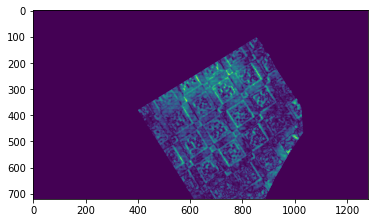

In [27]:
source_color = o3d.io.read_image(filelist1[-5])  
source_depth = o3d.io.read_image(filelist2[-5])  
filename = "/home/yunke/3dv_proj/0522/training_checkerboard/new_depth_img/"+filelist2[-5][54:]

new_depth_img = depth_to_new_depth(source_color,source_depth,filename)
o3d_new_depth_img = o3d.geometry.Image(new_depth_img)

org_err_img,org_data = get_err_image(source_color,source_depth)
new_err_img,new_data = get_err_image(source_color,o3d_new_depth_img) 

plt.imshow(org_err_img)

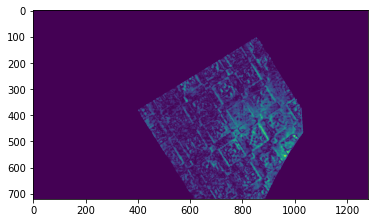

In [28]:
plt.imshow(new_err_img)
plt.savefig('/home/yunke/3dv_proj/bias correction/plot/rf_1.eps')

In [29]:
import seaborn as sns

sns_plot = sns.heatmap(org_std_err_img)
plt.savefig('/home/yunke/3dv_proj/bias correction/plot/org_std_err.png',dpi=400)

NameError: name 'org_std_err_img' is not defined

In [ ]:
sns.heatmap(org_ave_err_img, center=0)
plt.savefig('/home/yunke/3dv_proj/bias correction/plot/org_ave_err.png',dpi=400)

In [ ]:
sns.heatmap(new_ave_err_img,center=0)
plt.savefig('/home/yunke/3dv_proj/bias correction/plot/rf_ave_err.png',dpi=400)

In [ ]:
sns.heatmap(new_std_err_img)
plt.savefig('/home/yunke/3dv_proj/bias correction/plot/rf_std_err.png',dpi=400)

In [30]:
#err & pixel position
org_ave_err_img = np.zeros((720,1280))
new_ave_err_img = np.zeros((720,1280))
org_std_err_img = np.zeros((720,1280))
new_std_err_img = np.zeros((720,1280))

org_l = len(org_datas)
org_n = np.ones((720,1280))
for i in range(1,org_l,10):
    u = int(org_datas[i][0])
    v = int(org_datas[i][1])
    org_ave_err_img[v,u]+=(org_datas[i][3]-org_datas[i][2])
    org_std_err_img[v,u]+=(org_datas[i][3]-org_datas[i][2])**2
    org_n[v,u]+=1
    
new_l = len(new_datas)
new_n = np.ones((720,1280))
for i in range(1,new_l,10):
    u = int(new_datas[i][0])
    v = int(new_datas[i][1])
    new_ave_err_img[v,u]+=(new_datas[i][3]-new_datas[i][2])
    new_std_err_img[v,u]+=(new_datas[i][3]-new_datas[i][2])**2
    new_n[v,u]+=1

org_ave_err_img = org_ave_err_img/org_n
new_ave_err_img = new_ave_err_img/new_n
org_std_err_img = np.sqrt(org_std_err_img/org_n)
new_std_err_img = np.sqrt(new_std_err_img/new_n)
    

0.0018605548176486382


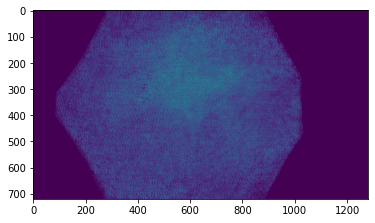

In [31]:
print(np.mean(org_std_err_img))

plt.imshow(org_std_err_img)

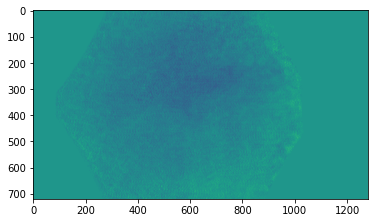

In [32]:
plt.imshow(org_ave_err_img)

0.0013667026197855497


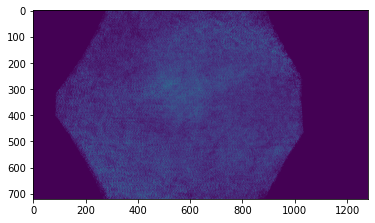

In [33]:
print(np.mean(new_std_err_img))

plt.imshow(new_std_err_img)

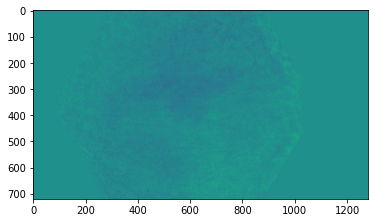

In [34]:
plt.imshow(new_ave_err_img)

In [35]:
#compute mean, std, RMSE
org_mean = np.mean(org_e)
org_rmse = np.sqrt(np.mean(np.square(org_e)))
org_std = np.std(org_e)

new_mean = np.mean(new_e)
new_rmse = np.sqrt(np.mean(np.square(new_e)))
new_std = np.std(new_e)
print(org_mean)
print(org_rmse)
print(org_std)
print(new_mean)
print(new_rmse)
print(new_std)

-0.0031369124473912876
0.005344544317755826
0.00432711615996817
-0.0011946365513216418
0.0040488795611117335
0.0038686262691858308


In [42]:
alpha=0
error = 0
errors = []
data_array = np.asarray(org_datas)
D = np.zeros(1280*720)
molecular = np.zeros(1280*720)
denominator = np.zeros(1280*720)
for i in range(data_array.shape[0]):
    idx = int(data_array[i,1]-1)*1280+int(data_array[i,0])-1
    molecular[idx] += (1/data_array[i,3]-1/data_array[i,2]) * np.exp(-alpha/data_array[i,2])
    denominator[idx] += np.exp(-2*alpha/data_array[i,2])
for i in range(1280*720):
    if denominator[i]!=0:
        D[i] = molecular[i]/denominator[i]
for i in range(data_array.shape[0]):
    idx = int(data_array[i,1]-1)*1280+int(data_array[i,0])-1
    error += (data_array[i,3] - 1/(1/data_array[i,2] + D[idx]*np.exp(-alpha*1/data_array[i,2])))**2
    errors.append(data_array[i,3] - 1/(1/data_array[i,2] + D[idx]*np.exp(-alpha*1/data_array[i,2])))

print("error=%f" %error)
RMSE = np.sqrt(error/data_array.shape[0])
print("error=%f" %RMSE)

error=180.728384
error=0.004329


In [45]:
print(np.mean(errors))

0.0006436013740980979


In [44]:
print(np.std(errors))

0.0042809749168592716
